<a href="https://colab.research.google.com/github/Akkki28/SparseMax-Transformers/blob/main/SparseMax_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
import seaborn as sns
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
class SparsemaxFunction(Function):
    @staticmethod
    def forward(ctx, input, dim):
        ctx.dim = dim
        input = input.transpose(0, dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, dtype=input.dtype, device=input.device).view(1, -1)
        range = range.expand_as(zs)

        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        zs_sparse = is_gt * zs

        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        output = torch.max(torch.zeros_like(input), input - taus)

        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, ctx.dim)

        ctx.save_for_backward(output)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        dim = ctx.dim

        nonzeros = torch.ne(output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return grad_input, None


In [3]:
class Sparsemax(nn.Module):
    def __init__(self, dim=None):
        super(Sparsemax, self).__init__()
        self.dim = -1 if dim is None else dim

    def forward(self, input):
        return SparsemaxFunction.apply(input, self.dim)

In [4]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)

    sparsemax = Sparsemax(dim=-1)
    attention = sparsemax(attn_logits)

    values = torch.matmul(attention, v)
    return values, attention

In [5]:
seq_len, d_k = 3, 2
seq_len, d_k = 3, 2
q_values = torch.tensor([[-0.1, -0.2], [0.3, 0.4], [0.5, 0.6]])
k_values = torch.tensor([[0.7, -0.8], [0.9, 1.0], [1.1, 1.2]])
v_values = torch.tensor([[1.3, 1.4], [1.5, -1.6], [1.7, 1.8]])

q = q_values
k = k_values
v = v_values


values, attention = scaled_dot_product(q, k, v)

In [6]:
def plot_attention_maps(attention, title='Attention Map'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention.detach().numpy(), annot=True, cmap='viridis', xticklabels=[f"Token {i}" for i in range(seq_len)], yticklabels=[f"Token {i}" for i in range(seq_len)])
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(title)
    plt.show()


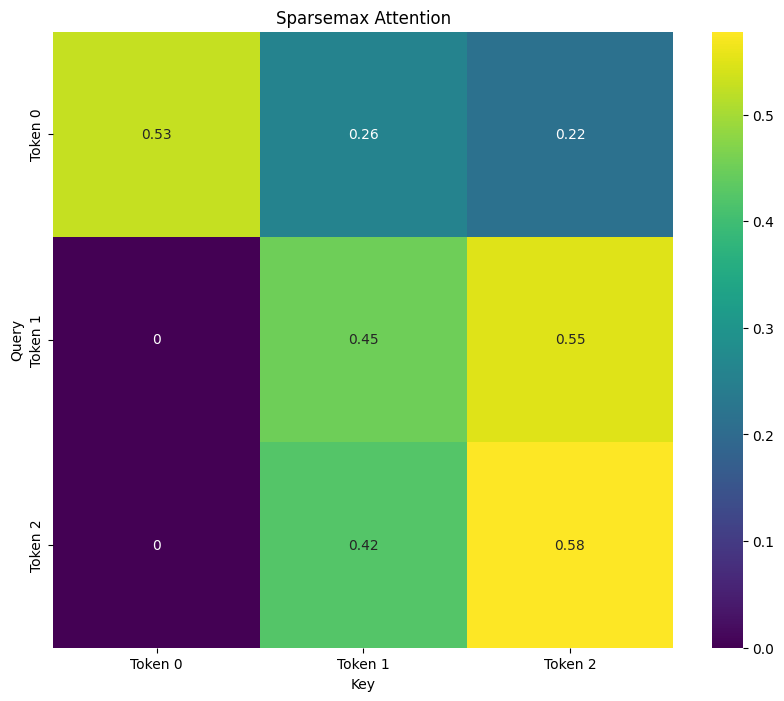

In [7]:
plot_attention_maps(attention, title='Sparsemax Attention')